# Descargando el dataset de kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
 from google.colab import files
 # Escoger json descargado de la API de tu cuenta de kaggle
 files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip intel-image-classification.zip

#Red VGG16

Importando las librerías necesarias

In [ ]:
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from random import randint

import shutil
import random
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
import matplotlib.gridspec as gridspec

import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics

from tensorflow import keras

from IPython.display import SVG
import tensorflow.keras.utils as Utils

Función para cargar las imágenes desde un directorio

In [ ]:
# directory: Directorio donde la etiqueta de cada clase está 
# dentro de un folder con el nombre de su etiqueta
# get_images: devuelve una lista con las imágenes y otra lista con las etiquetas
# de las imágenes
def get_images(directory):
    Images = []
    Labels = []  # 0 - Building , 1 - forest, 2 - glacier, 3 - mountain, 4 - Sea , 5 - Street
    label = 0
    
    for labels in os.listdir(directory):
        if labels == 'glacier':
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels):
            image = cv2.imread(directory+labels+r'/'+image_file)
            image = cv2.resize(image,(150,150)) # Reescalando imágenes porque algunas son de diferente tamaño
            Images.append(image)
            Labels.append(label)
    
    # Mezclando el dataset
    return shuffle(Images,Labels,random_state=817328462)

# class_code: número asignado a las diferentes etiquetas
# get_classlabel: devuelve una string con el nombre de la etiqueta
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [ ]:
# Cargando las imágenes
train_images, train_labels = get_images('seg_train/seg_train/')

# Convirtiendo las imágenes en un arreglo numpy
train_images = np.array(train_images)
train_labels = np.array(train_labels)

Mostramos algunas imágenes aleatorias de nuestro dataset

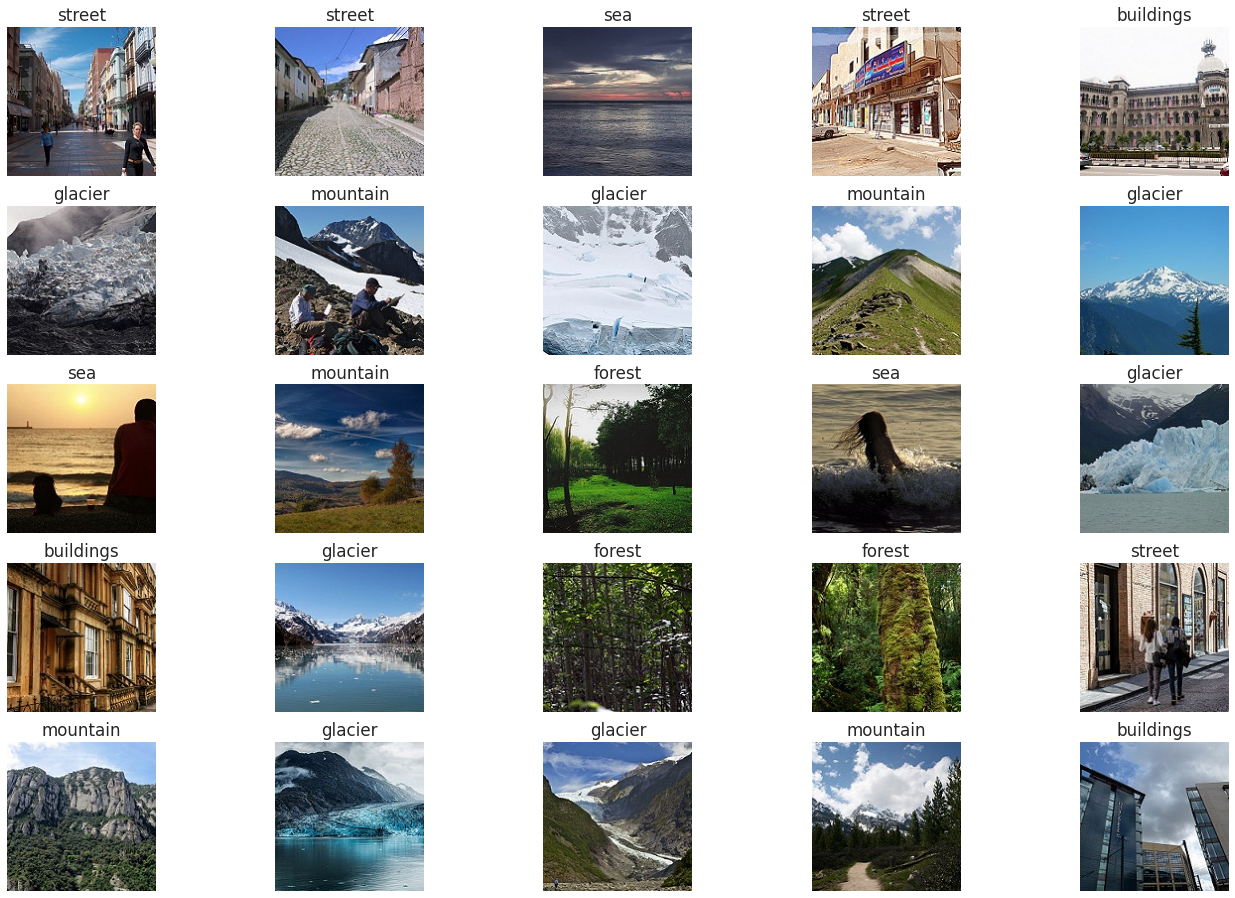

In [ ]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(train_images))
        ax[i,j].imshow(cv2.cvtColor(train_images[rnd_number], cv2.COLOR_BGR2RGB))
        ax[i,j].set_title(get_classlabel(train_labels[rnd_number]))
        ax[i,j].axis('off')

Cargamos el modelo de la CNN Xception con datos pre-entrenados con el dataset Image-net

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)

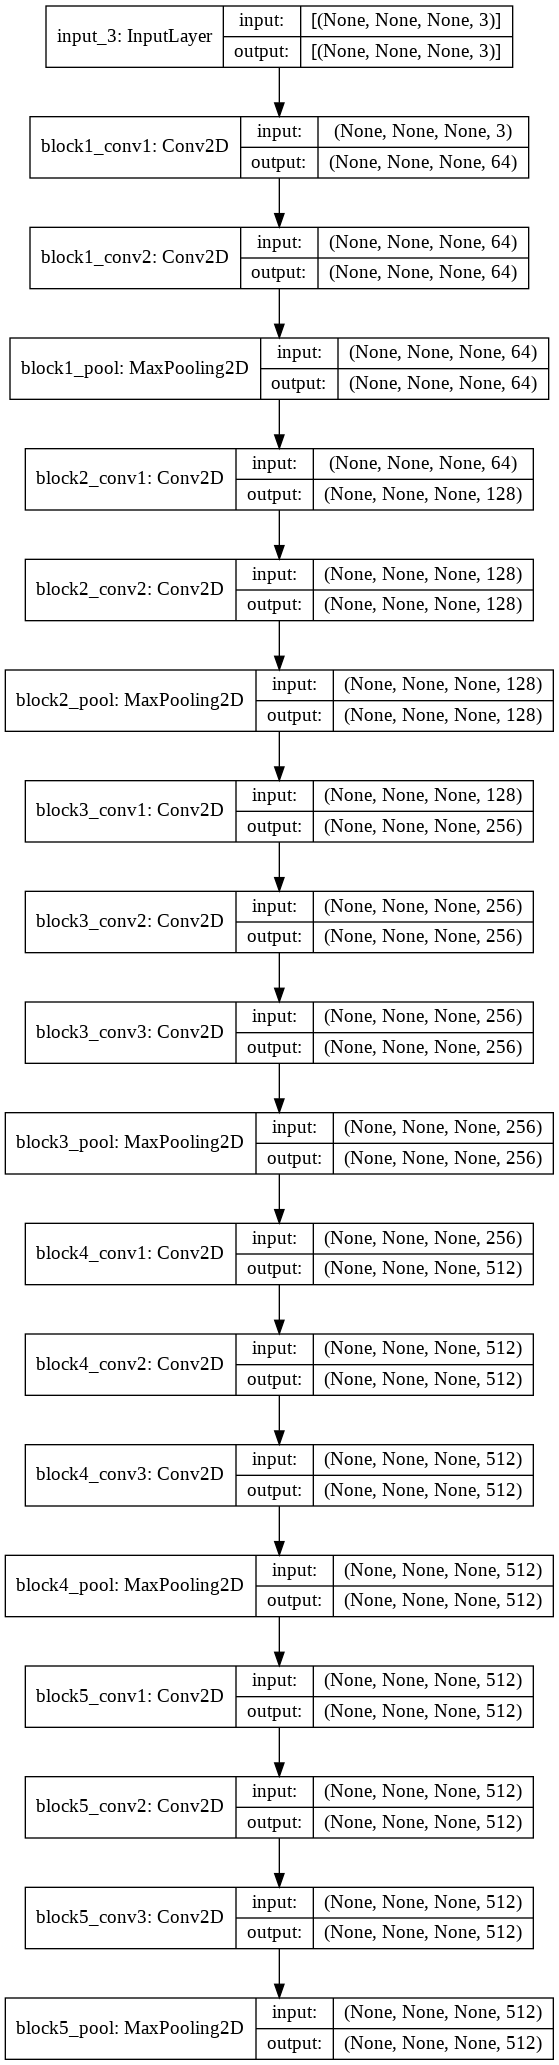

In [ ]:
SVG(Utils.model_to_dot(vgg16_model).create(prog='dot', format='svg'))
Utils.plot_model(vgg16_model,to_file='model.png',show_shapes=True)

Preprocesamos nuestras imágenes para que coincidan con el formato de las imágenes entrenadas de Image-net

In [ ]:
train_images = preprocess_input(train_images)

Le pasamos nuestras imágenes ya preprocesadas a la CNN para obtener los feature maps

In [ ]:
train_images = xception_model.predict(train_images)

Obtenemos las dimensiones de los feature maps para poder entrenar nuestra red

In [ ]:
n_train, x, y, z = train_images.shape
numFeatures = x * y * z
print(n_train, x, y, z)

14034 4 4 512


Ya que usamos la CNN xception para obtener los feature maps, procedemos a definir nuestra red para clasificar las imágenes

In [ ]:
model = tf.keras.Sequential()
model.add(Layers.Flatten(input_shape = (x,y,z)))
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 180)               1474740   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 1,498,196
Trainable params: 1,498,196
Non-trainable params: 0
______________________________________________

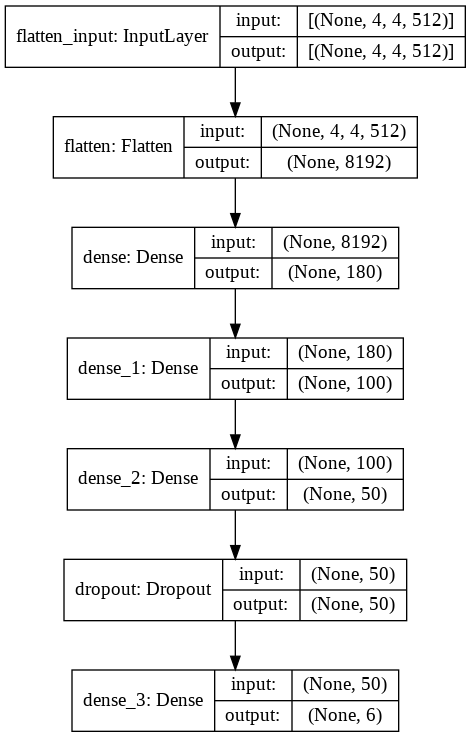

In [ ]:
SVG(Utils.model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)

Entrenamos la red

In [ ]:
hist = model.fit(train_images, train_labels, batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
351/351 [==============================] - 2s 4ms/step - loss: 1.0526 - accuracy: 0.7289 - val_loss: 0.4177 - val_accuracy: 0.8660
Epoch 2/15
351/351 [==============================] - 1s 4ms/step - loss: 0.4882 - accuracy: 0.8322 - val_loss: 0.5656 - val_accuracy: 0.8436
Epoch 3/15
351/351 [==============================] - 1s 4ms/step - loss: 0.3592 - accuracy: 0.8741 - val_loss: 0.4561 - val_accuracy: 0.8846
Epoch 4/15
351/351 [==============================] - 1s 3ms/step - loss: 0.3255 - accuracy: 0.8896 - val_loss: 0.4444 - val_accuracy: 0.8817
Epoch 5/15
351/351 [==============================] - 1s 4ms/step - loss: 0.2361 - accuracy: 0.9148 - val_loss: 0.5917 - val_accuracy: 0.8824
Epoch 6/15
351/351 [==============================] - 1s 3ms/step - loss: 0.2155 - accuracy: 0.9290 - val_loss: 0.6173 - val_accuracy: 0.8849
Epoch 7/15
351/351 [==============================] - 1s 3ms/step - loss: 0.2034 - accuracy: 0.9303 - val_loss: 0.4797 - val_accuracy: 0.8885
Epoch 

Una vez entrenada la red, plotearemos las gráficas de como evolucionó nuestra red con el paso de las épocas

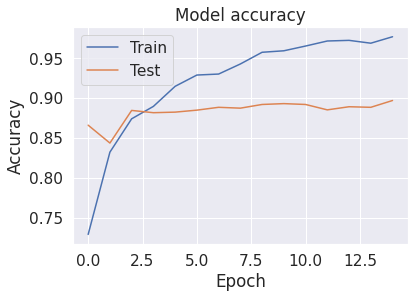

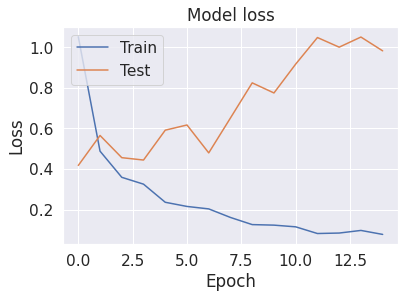

In [ ]:
plot.plot(hist.history['accuracy'])
plot.plot(hist.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(hist.history['loss'])
plot.plot(hist.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

Cargamos los datos de prueba

In [ ]:
test_images, test_labels = get_images('seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Preprocesamos los datos de prueba

In [ ]:
test_images = preprocess_input(test_images)

Obtenemos los feature maps de los datos de prueba

In [ ]:
test_images = xception_model.predict(test_images)

Evaluamos la precisión de nuestro modelo

In [ ]:
# batch_size: por defecto 32
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 0s 3ms/step - loss: 1.0081 - accuracy: 0.8900


Considerando la complejidad del dataset, una precisión de 0.88 es un resultado más que decente

Para analizar mejor los resultados de las predicciones, vamos a obtener los vectores de probabilidades para cada imágen de prueba, junto a su etiqueta predecida

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

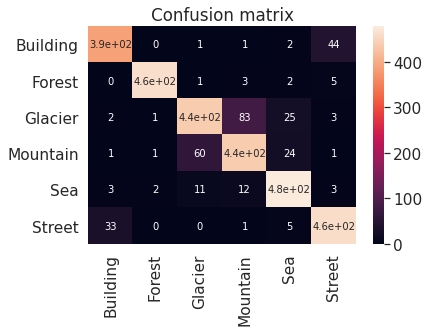

In [ ]:
class_names = ["Building" , "Forest", "Glacier", "Mountain", "Sea" , "Street"]

CM = confusion_matrix(test_labels, pred_labels)
ax = plot.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plot.show()

Nuestro modelo tuvo problemas en diferenciar las calles de los edificios, algo que no es muy difícil de entender por qué, además también podemos ver que tuvo dificultades diferenciando los glaciares de las montañas y océanos.

In [ ]:
test_images2, test_labels2 = get_images('seg_test/seg_test/')
test_images2 = np.array(test_images2)
test_labels2 = np.array(test_labels2)

También podemos analizar el vector de probabilidades para los casos en el cuál nuestro modelo se equivocó

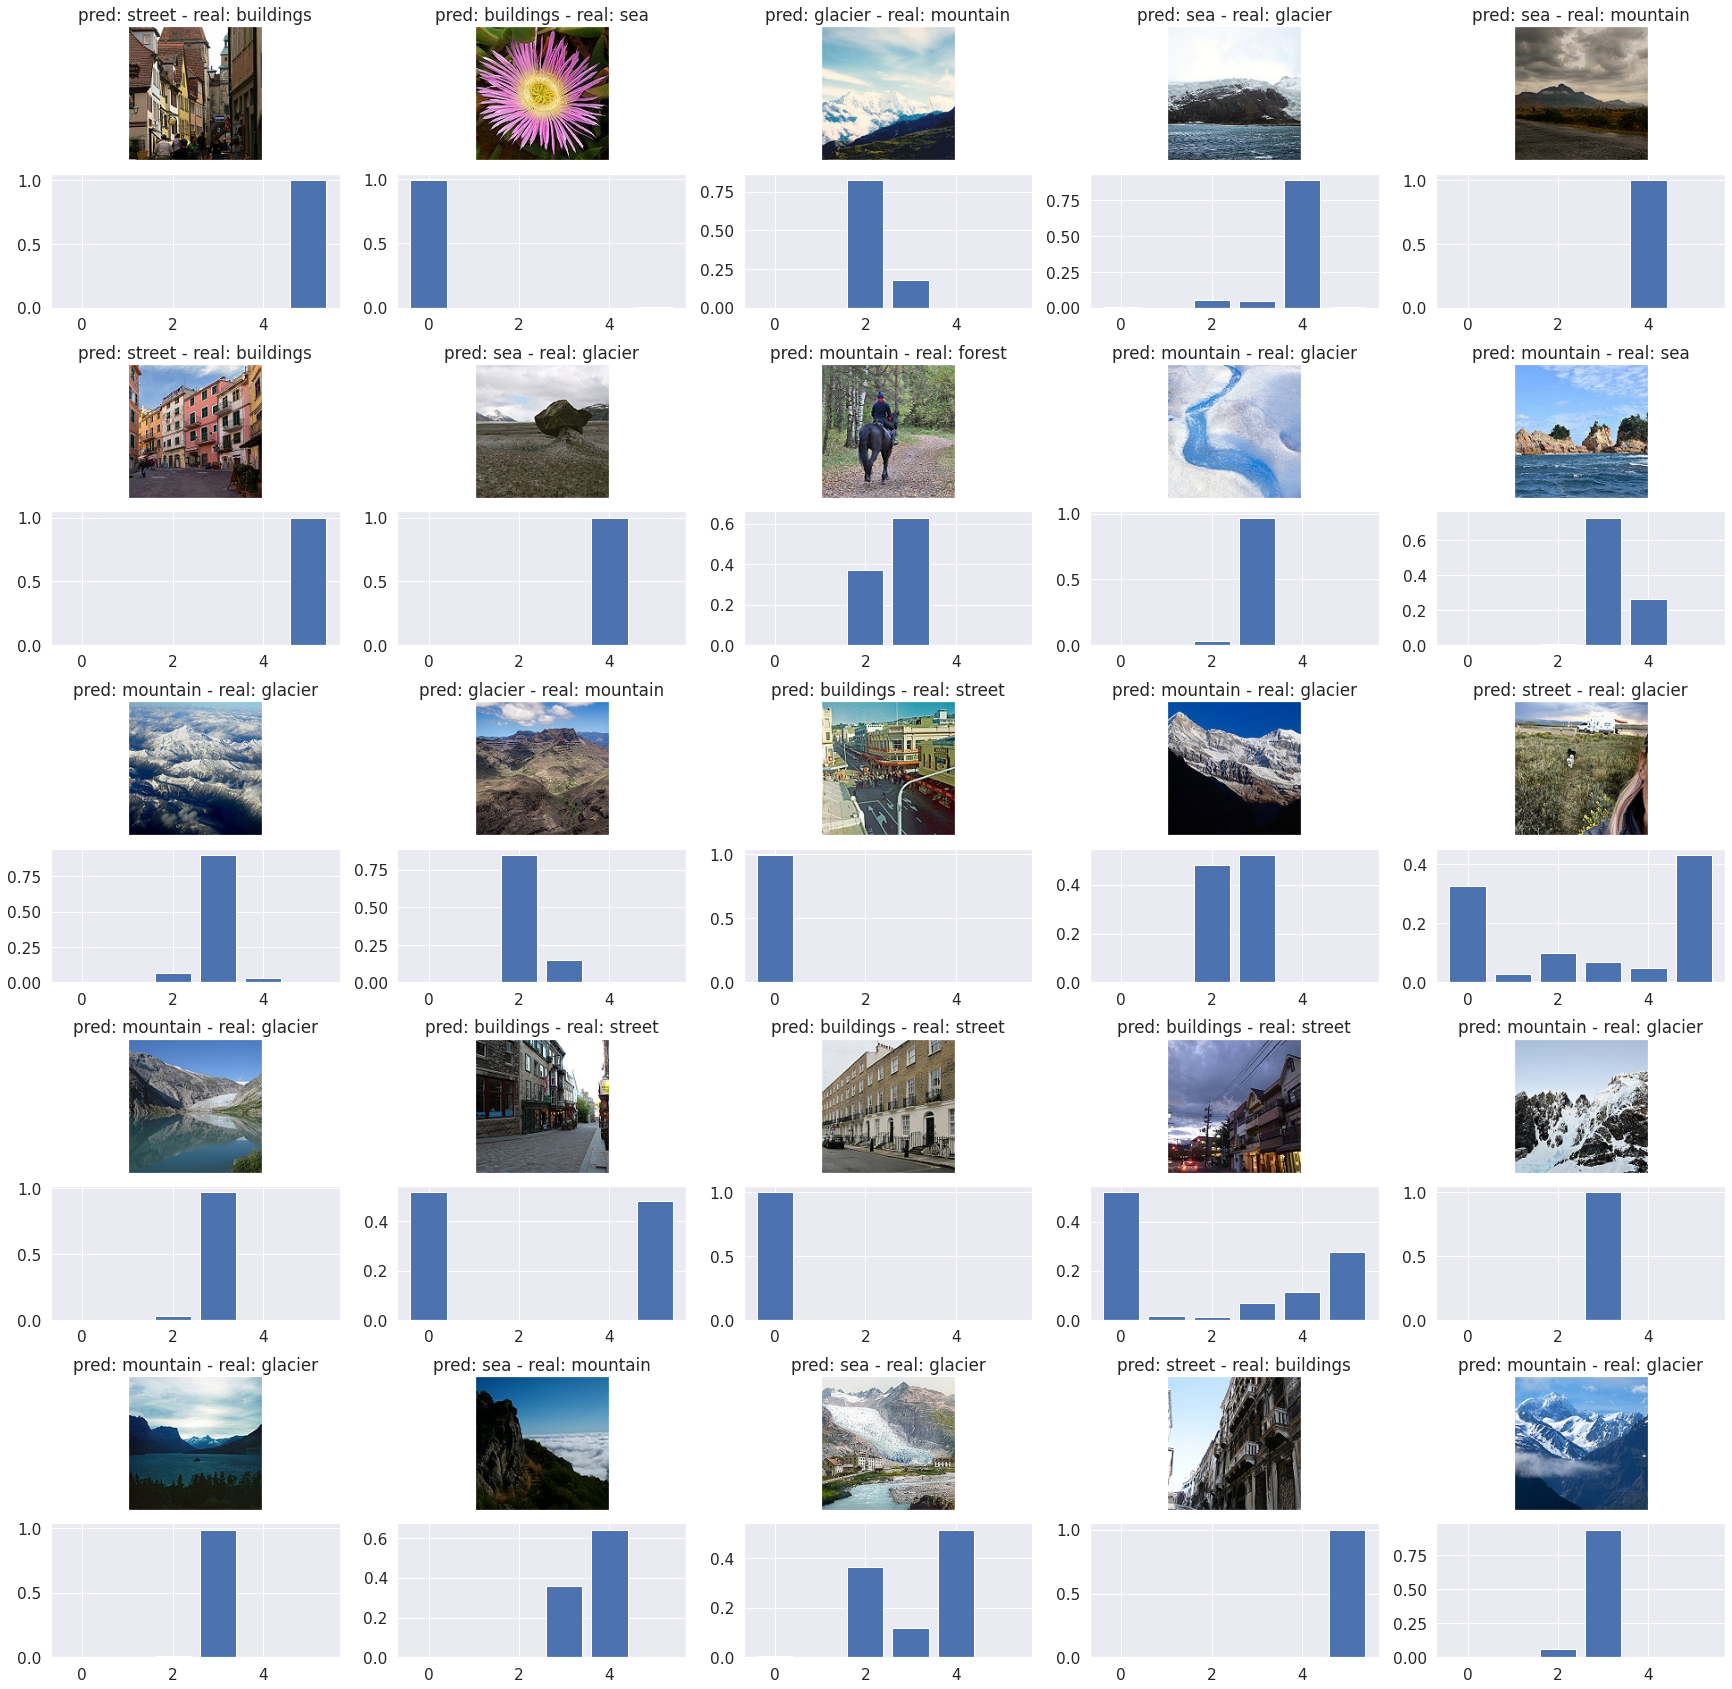

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

BOO = (test_labels == pred_labels)
mislabeled_indices = np.where(BOO == 0)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    pred_image = test_images2[mislabeled_indices[0][i]]
    pred_class = get_classlabel(pred_labels[mislabeled_indices[0][i]])
    pred_class2 = get_classlabel(test_labels[mislabeled_indices[0][i]])
    pred_prob = predictions[mislabeled_indices[0][i]]
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB))
            ax.set_title("pred: "+pred_class+ " - real: "+pred_class2)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()